# Large deformations and images

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
import os
import summerschool as ss
import scipy.interpolate as spi

In [2]:
# load a pair of images
fname = os.path.join('T1Images','Adt27-55_02_Adt27-55_02_MNI.img')
imgI = nib.load(fname)
nx = imgI.header['dim'][1:4]
dx = imgI.header['pixdim'][1:4]
# set up a domain
x0 = np.arange(nx[0])*dx[0] - np.mean(np.arange(nx[0])*dx[0])
x1 = np.arange(nx[1])*dx[1] - np.mean(np.arange(nx[1])*dx[1])
X0,X1 = np.meshgrid(x0,x1,indexing='ij')

fname = os.path.join('T1Images','Adt27-55_03_Adt27-55_03_MNI.img')
imgJ = nib.load(fname)

<IPython.core.display.Javascript object>


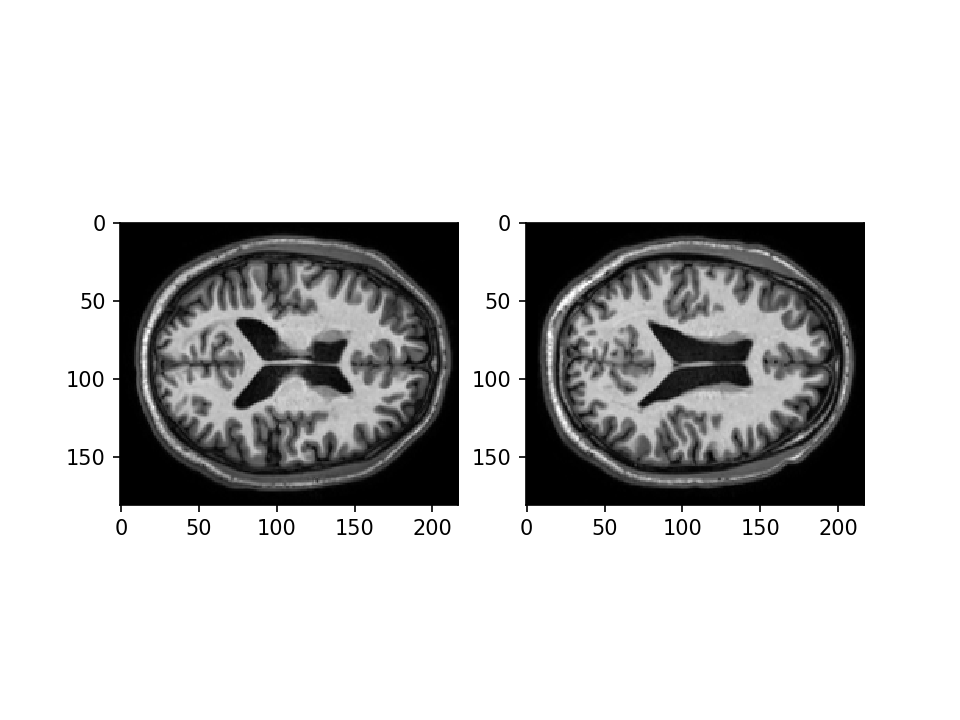

In [3]:
# start with a 2D example
I = imgI.get_data()[:,:,imgI.shape[2]//2,0] # note last axes is time, we'd like to remove it
J = imgJ.get_data()[:,:,imgJ.shape[2]//2,0] # note last axes is time, we'd like to remove it

f,ax = plt.subplots(1,2)
ax[0].imshow(I,cmap='gray')
ax[0].set_aspect('equal')
ax[1].imshow(J,cmap='gray')
ax[1].set_aspect('equal')

## The failure of smooth displacement vector fields
Smooth displacement fields generate invertible transformations as long as they are small enough.

But as they grow bigger, they can become lose invertability no matter how smooth they are

<IPython.core.display.Javascript object>


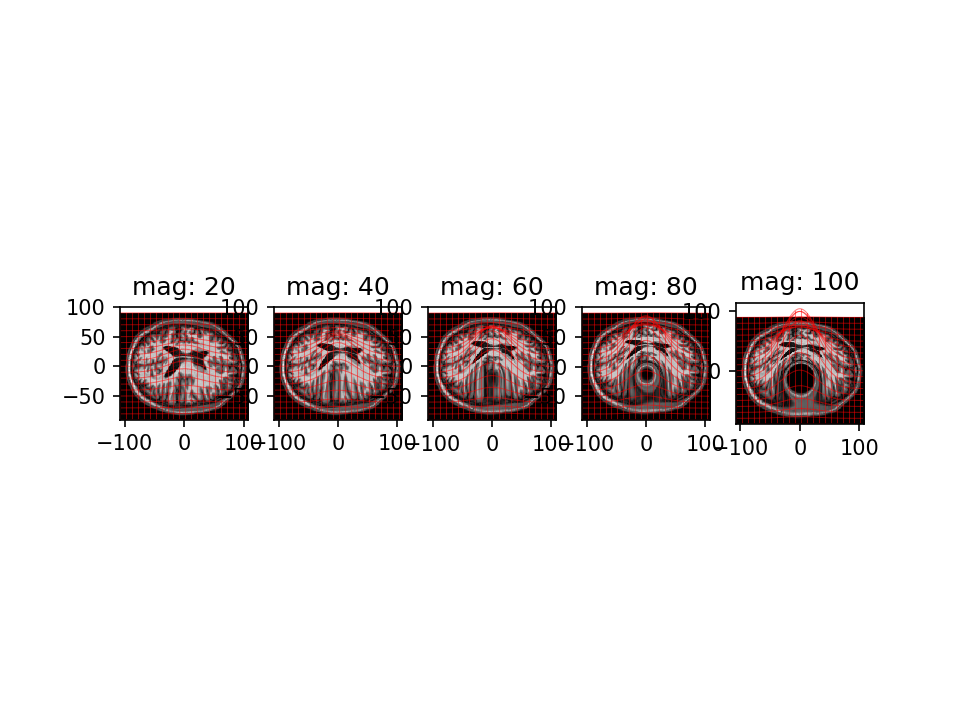

In [4]:
# example deformation and action on image
gaussian = np.exp(-(X0**2 + X1**2)/(2.0*30.0**2))
magnitudes = [20,40,60,80,100]

f,ax = plt.subplots(1,len(magnitudes),sharex=True)

for magnitude,a in zip(magnitudes,ax):
    v0 = gaussian*magnitude
    v1 = np.zeros_like(v0)
    phi0 = X0+v0
    phi1 = X1+v1
    phiinv0 = X0-v0
    phiinv1 = X1-v1
    interp_args = {'method':'linear','bounds_error':False,'fill_value':0}
    phiI = spi.interpn([x0,x1],I,np.stack([phiinv0,phiinv1],axis=-1),**interp_args)


    stride = 10
    imshow_args = dict(cmap='gray',extent=[x1[0],x1[-1],x0[0],x0[-1]],origin='lower')
    a.imshow(phiI,**imshow_args)
    ss.plot_grid(phi1,phi0,ax=a,rstride=stride,cstride=stride,color='r',linewidth=0.5,alpha=0.5)
    a.set_aspect('equal')
    a.set_title('mag: {}'.format(magnitude))
    

## Combining small deformations under composition works
If any two transformations are invertable, than so is their composition.  We can build up large transformations by composing small ones.

<IPython.core.display.Javascript object>


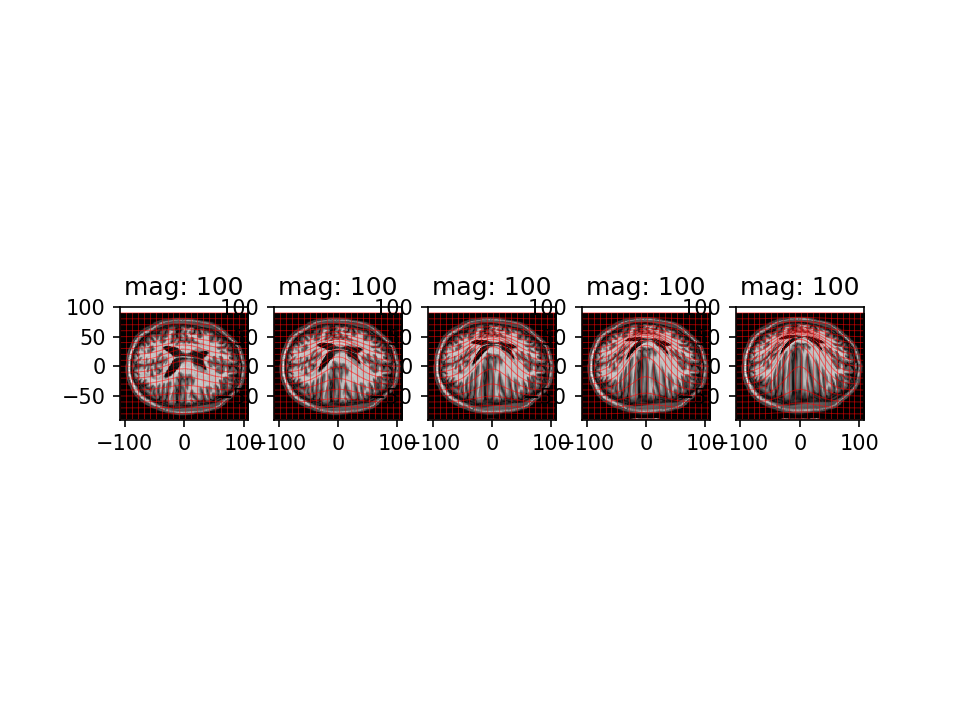

In [5]:
f,ax = plt.subplots(1,len(magnitudes),sharex=True)

mag = magnitudes[0]
interp_args = dict(bounds_error=False,fill_value=0,method='linear')
stride = 10
imshow_args = dict(cmap='gray',extent=[x1[0],x1[-1],x0[0],x0[-1]],origin='lower')
    
phi0 = np.array(X0)
phi1 = np.array(X1)
phiinv0 = np.array(X0)
phiinv1 = np.array(X1)
for a in ax:
    v0 = gaussian*mag
    v1 = np.zeros_like(v0)
    # update using composition
    # recall that on a computer, composition is just interpolation
    phi0_ = phi0 + spi.interpn([x0,x1],v0,np.stack([phi0,phi1],axis=-1),**interp_args)
    phi1 = phi1 + spi.interpn([x0,x1],v1,np.stack([phi0,phi1],axis=-1),**interp_args)
    phi0 = phi0_
    
    # update to the inverse
    phiinv0 = spi.interpn([x0,x1],phiinv0,np.stack([X0-v0,X1-v1],axis=-1),**interp_args)
    phiinv1 = spi.interpn([x0,x1],phiinv1,np.stack([X0-v0,X1-v1],axis=-1),**interp_args)
    
    phiI = spi.interpn([x0,x1],I,np.stack([phiinv0,phiinv1],axis=-1),**interp_args)
    
    a.imshow(phiI,**imshow_args)
    ss.plot_grid(phi1,phi0,ax=a,rstride=stride,cstride=stride,color='r',linewidth=0.5,alpha=0.5)
    a.set_aspect('equal')
    a.set_title('mag: {}'.format(magnitude))
    

## Flows arise in the limit of composition

Let $\varphi_{t_0} = id$, then $\varphi_{t_1} = (id+v_{t_0}\Delta t)\circ \varphi_{t_0}$, and $\varphi_{t_{n+1}} = (id+v_{t_n}\Delta t)\circ \varphi_{t_n}$.

This can be written as $\varphi_{t_{n+1}} = \varphi_{t_n} + \Delta T v_{t_n}(\varphi_{t_n})$.  Rearranging gives 
\begin{align*}
\frac{\varphi_{t_{n+1}} - \varphi_{t_n}}{\Delta t} = v_{t_n}(\varphi_{t_n})
\end{align*}

Passing to the limit gives us Euler's equation
\begin{align*}
\frac{d}{dt} \varphi_t &= v_t(\varphi_t)
\end{align*}
which describes an the flow of the ODE $\dot x = v_t(x)$.


## The inverse deforms under optical flow

Since images deform by composing with $\varphi^{-1}$, we need to understand how $\varphi^{-1}$ flows over time under $v$.

Differentiate the identity transformation to get
\begin{align*}
0 &=\frac{d}{dt}id\\
&= \frac{d}{dt}(\varphi_t(\varphi_t^{-1}))\\
&=\frac{d}{dt}\varphi_t(\varphi_t^{-1}) + D\varphi_t(\varphi_t^{-1})\frac{d}{dt}\varphi_t^{-1}\\
&=v_t + D\varphi_t(\varphi_t^{-1})\frac{d}{dt}\varphi_t^{-1}
\end{align*}

We plugged in Euler's equation for the first term.  Note that we can understand the second term by applying the chain rule
\begin{align}
id &= D(x)\\
&= D(\varphi(\varphi^{-1}))\\
&= D\varphi(\varphi^{-1})D\varphi^{-1}
\end{align}
which implies that $[D\varphi(\varphi^{-1})]^{-1} = D\varphi^{-1}$.  We can use this to solve the above equation
\begin{align*}
\frac{d}{dt}\varphi_t^{-1} &= -D\varphi_t^{-1}v_t
\end{align*}
This is just the optical flow equation https://en.wikipedia.org/wiki/Optical_flow on each component of $\varphi^{-1}$.

This equation is generally solved numerically using the method of characteristics https://en.wikipedia.org/wiki/Method_of_characteristics which we will employ here.

## The image deforms under optical flow
Using the above formula for $\frac{d}{dt}\varphi^{-1}_t$, we can find a formula for $\frac{d}{dt}I_t$.
\begin{align*}
\frac{d}{dt} I_t &= \frac{d}{dt}I_0(\varphi^{-1}_t)\\
&= D I_0 (\varphi^{-1}_t)\frac{d}{dt} \varphi^{-1}_t\\
&\stackrel{(a)}{=} -D I_0 (\varphi^{-1}_t) D\varphi^{-1}_t v_t\\
&\stackrel{(b)}{=} -D[I_0 (\varphi^{-1}_t)] v_t\\
&= -D I_t v_t
\end{align*}
where in (a) we applied the optical flow equation derived above, and in (b) we simply group terms using the chain rule.

<IPython.core.display.Javascript object>


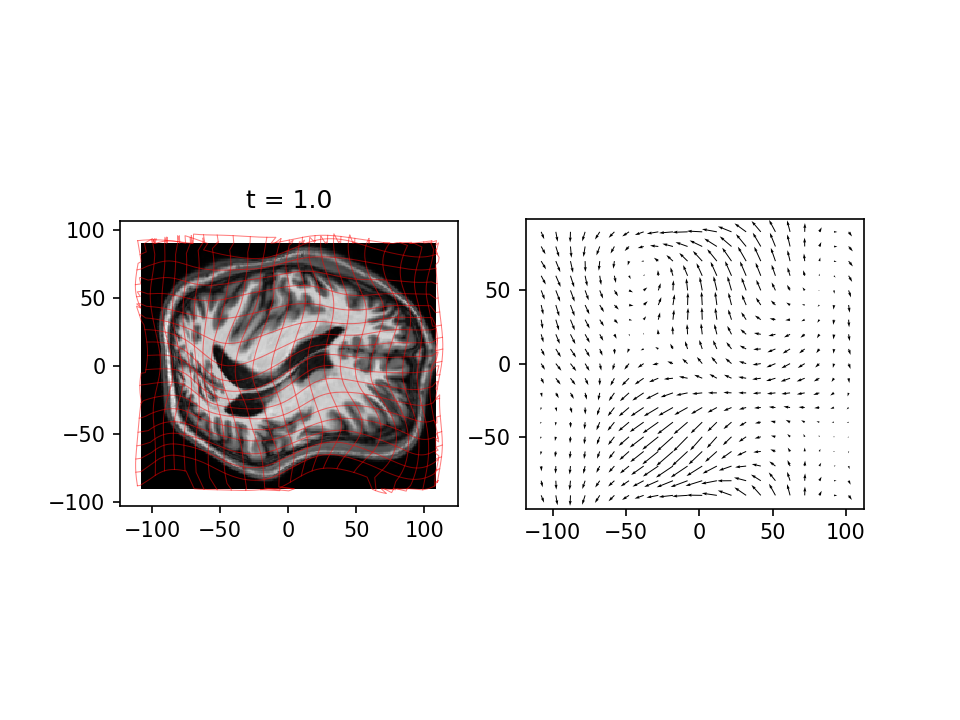

In [6]:
# example of flows
nt = 5
dt = 1.0/nt

# encode our energy operator in the Fourier domain using discrete derivatives
f0 = np.arange(nx[0])/(dx[0]*nx[0])
f1 = np.arange(nx[1])/(dx[1]*nx[1])
F0,F1 = np.meshgrid(f0,f1,indexing='ij')
a = 10.0 # a scale in mm
p = 2
Ahat = (1.0 - 2.0*a**2*((np.cos(2.0*np.pi*dx[0]*F0) - 1.0)/dx[0]**2 + (np.cos(2.0*np.pi*dx[1]*F1) - 1.0)/dx[1]**2))**(2.0*p)
Khat = 1.0/Ahat
K = np.fft.ifft2(Khat,nx[:2]).real

# make a random flow
mag = 2000.0
vt0 = np.random.randn(nx[0],nx[1],nt)*mag
vt1 = np.random.randn(nx[0],nx[1],nt)*mag
# smooth it
vt0 = np.fft.ifftn(np.fft.fftn(vt0,axes=[0,1])*Khat[:,:,None],axes=[0,1]).real
vt1 = np.fft.ifftn(np.fft.fftn(vt1,axes=[0,1])*Khat[:,:,None],axes=[0,1]).real

# now lets flow it forward
phi0 = np.array(X0)
phi1 = np.array(X1)
phiinv0 = np.array(X0)
phiinv1 = np.array(X1)

f,ax = plt.subplots(1,2)
for t in range(nt):
    v0 = vt0[:,:,t]
    v1 = vt1[:,:,t]
    # update phi using Euler's equation    
    phi0_ = phi0 + spi.interpn([x0,x1],v0,np.stack([phi0,phi1],axis=-1),**interp_args)*dt
    phi1 = phi1 + spi.interpn([x0,x1],v1,np.stack([phi0,phi1],axis=-1),**interp_args)*dt
    phi0 = phi0_
    
    # update phiinv using method of characteristics
    X0s = X0-v0*dt
    X1s = X1-v1*dt
    interp_args_phiinv = dict(interp_args)
    interp_args_phiinv['fill_value'] = None
    #phiinv0 = spi.interpn([x0,x1],phiinv0,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)
    #phiinv1 = spi.interpn([x0,x1],phiinv1,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)
    # here we need to deal with boundary conditions better
    phiinv0 = spi.interpn([x0,x1],phiinv0-X0,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)+X0s
    phiinv1 = spi.interpn([x0,x1],phiinv1-X1,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)+X1s
    
    # act on the image
    phiI = spi.interpn([x0,x1],I,np.stack([phiinv0,phiinv1],axis=-1),**interp_args)

    [a.cla() for a in ax]
    ax[0].imshow(phiI,**imshow_args)
    ss.plot_grid(phi1,phi0,ax=ax[0],rstride=stride,cstride=stride,color='r',linewidth=0.5,alpha=0.5)
    ax[0].set_aspect('equal')
    ax[0].set_title('t = {:3.1f}'.format((t+1)*dt))
    
    ax[1].quiver(X1[::stride,::stride],X0[::stride,::stride],
             v1[::stride,::stride],v0[::stride,::stride])
    ax[1].set_aspect('equal')    
    f.canvas.draw()

## Finding the optimal flow
We write an optimization problem like
\begin{align*}
E &= \frac{1}{2}\int_0^1 \int_X v^T(x)Av(x) dx dt + \frac{1}{2\sigma^2}\int |I(\varphi_1^{-1}(x)) - J(x)|^2dx
\end{align*}
where the the diffeomorphism is linked to the velocity by Euler's equation $\frac{d}{dt}\varphi_t = v_t(\varphi_t)$, and $A$ is our energy operator from before.

One of the nicer approaches to solving this problem comes from optimal control.  We'll define the state of our system as the image $I$, which is governed by dynamics $\dot I = -DI v$ (optical flow) with $I_0 = I_{\text{template}}$, where $v$ is the control.

These dynamics are enforced by a Lagrange multiplier, or costate, $\lambda$.  We can write an augmented cost function $L$ as
\begin{align*}
L = E + \int_0^1 \int_X \lambda_t(x)(\frac{d}{dt}I_t(x) + DI_t(x) v_t(x))dxdt
\end{align*}
We can find minimizers by taking perturbations with respect to $I$ and $v$. 

First take a perturbation with respect to $v$
\begin{align}
&\frac{d}{d\epsilon}  \frac{1}{2}\int_0^1 \int_X (v_t + \epsilon \delta v_t)^T(x)A(v_t + \epsilon \delta v_t)(x) dx dt + \frac{1}{2\sigma^2}\int_X |I_1(x) - J(x)|^2dx + \int_0^1 \int_X \lambda_t(x)(\frac{d}{dt}I_t(x) + DI_t(x) (v_t + \epsilon \delta v_t)(x))dxdt \bigg|_{\epsilon = 0}\\
&=  \int_0^1 \int_X Av_t^t(x) \delta v(x) + \int_0^1\int_X \lambda_t(x) DI_t(x) \delta v_xdx dt
\end{align}

If this is true for all perturbations, we must have
\begin{align}
d_vE &= Av_t + \lambda_t DI_t
\end{align}
for numerical reasons we usually work with the gradient vector by acting with $K$, the Green's kernel of $A$
\begin{align}
\nabla_v E &= v_t + K*\lambda_t DI_t
\end{align}

Now we'll extremize over $I$
\begin{align*}
&\frac{d}{d \epsilon}\frac{1}{2}\int_0^1 \int_X v_t^T(x)Av_t(x) dx dt + \frac{1}{2\sigma^2}\int_X |I_1(x) + \epsilon \delta I_1(x) - J(x)|^2dx + \int_0^1 \int_X \lambda_t(x)(\frac{d}{dt}(I_t + \epsilon \delta I_t)(x)  + D(I_t + \epsilon \delta I_t)(x) v_t(x))dxdt \bigg|_{\epsilon = 0}\\
&= \frac{1}{\sigma^2}\int_X (I_1(x)  - J(x))\delta I_1(x) dx + \int_0^1\int_X \lambda_t(x) \frac{d}{dt}\delta I_t(x) dxdt + \int_0^1 \int_X \lambda_t(x) D \delta I_t(x) v_t(x)dxdt
\end{align*}
We'll use integration by parts on the middle term, remembering that $\delta I_0 = 0$, and we'll use the divergence theorem on the final term.
\begin{align*}
\frac{1}{\sigma^2}\int_X (I_1(x)  - J(x))\delta I_1(x) dx + -\int_0^1\int_X \frac{d}{dt}\lambda_t(x) \delta I_t(x) dxdt + \int_X \lambda_1(x) \delta I_1(x)dx - \int_0^1 \int_X \text{div}[\lambda_t(x) v_t(x)] \delta I_t(x)dxdt
\end{align*}

For this to vanish for all perturbations the we must have have the boundary conditions $\lambda_1 = -\frac{1}{\sigma^2}(I_1 - J)$, and the dynamical equation
\begin{align*}
\frac{d}{dt}\lambda = \text{div}[\lambda v]
\end{align*}
This equation has an explicit solution in terms of the diffeomorphism.  If $\varphi_{1t}$ is the diffeomorphism generated from integrating $v$ from time 1 backwards to time $t$, then the solution is
\begin{align}
\lambda_t &= \lambda_1(\varphi_{1t}^{-1})|D\varphi_{1t}^{-1}|
\end{align}

Putting this all together gives a nice equation for the gradient that we can use for an optimization algorithm
\begin{align*}
\nabla_v E &= v -K*(I(\varphi_t^{-1}) - J(\varphi_{1t}^{-1})) \nabla I_t |D\varphi_{1t}^{-1}|
\end{align*}

<IPython.core.display.Javascript object>


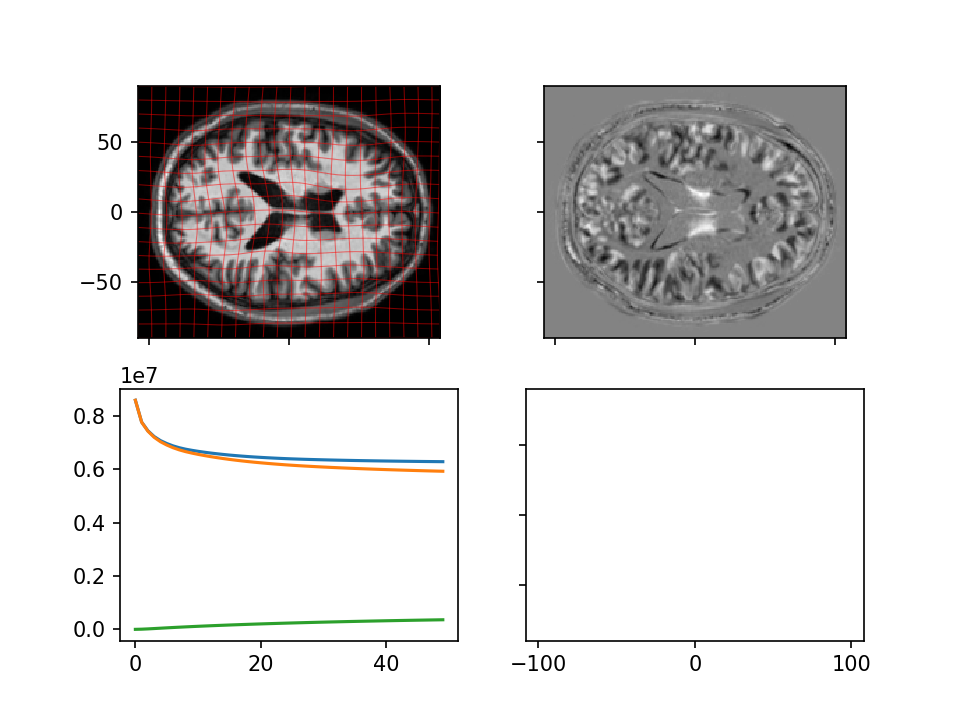

In [7]:
# now run matching
# for display, create plots with shared axis
f,ax = plt.subplots(2,2,sharex=True,sharey=True)
# for plotting energy, no shared axis
f.delaxes(ax[1][0])
ax[1][0] = f.add_subplot(2,2,3)

# parameters
sigma = 2e0
niter = 50
epsilon = 2.0e-2

# initialize
vt0 = np.zeros((nx[0],nx[1],nt))
vt1 = np.zeros((nx[0],nx[1],nt))
It = np.zeros((nx[0],nx[1],nt+1))
It[:,:,0] = I

EMAll = []
ERAll = []
EAll = []
for it in range(niter):
    # compute the deformed image by flowing over time
    phi0 = X0
    phi1 = X1
    phiinv0 = X0
    phiinv1 = X1
    ER = 0.0
    for t in range(nt):
        v0 = vt0[:,:,t]
        v1 = vt1[:,:,t]
        # update phi using Euler's equation   
        # this is not necessary for the algorithm, only visualization
        phi0_ = phi0 + spi.interpn([x0,x1],v0,np.stack([phi0,phi1],axis=-1),**interp_args)*dt
        phi1 = phi1 + spi.interpn([x0,x1],v1,np.stack([phi0,phi1],axis=-1),**interp_args)*dt
        phi0 = phi0_

        # update phiinv using method of characteristics
        X0s = X0-v0*dt
        X1s = X1-v1*dt
        #phiinv0 = spi.interpn([x0,x1],phiinv0,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)
        #phiinv1 = spi.interpn([x0,x1],phiinv1,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)
        # here we need to deal with boundary conditions better
        phiinv0 = spi.interpn([x0,x1],phiinv0-X0,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)+X0s
        phiinv1 = spi.interpn([x0,x1],phiinv1-X1,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)+X1s

        # act on the image
        It[:,:,t+1] = spi.interpn([x0,x1],I,np.stack([phiinv0,phiinv1],axis=-1),**interp_args)
    
        # calculate the energy of the flow
        Av0 = np.fft.ifftn(np.fft.fftn(v0)*Ahat).real
        Av1 = np.fft.ifftn(np.fft.fftn(v1)*Ahat).real
        ER += np.sum(v0*Av0 + v1*Av1)*0.5*dx[0]*dx[1]*dt
        
    ax[0,0].cla()
    ax[0,0].imshow(It[:,:,-1],**imshow_args)
    ss.plot_grid(phi1,phi0,ax=ax[0,0],color='r',alpha=0.5,linewidth=0.5,rstride=stride,cstride=stride)
    
    # error
    err = It[:,:,-1] - J
    lambda1 = -(err)/sigma**2
    ax[0,1].cla()
    ax[0,1].imshow(err,**imshow_args)
    
    EM = np.sum(err**2/(2.0*sigma**2))*dx[0]*dx[1]
    EMAll.append(EM)        
    ERAll.append(ER)    
    E = ER+EM
    EAll.append(E)
    ax[1,0].cla()
    ax[1][0].plot(EAll)
    ax[1][0].plot(EMAll)
    ax[1][0].plot(ERAll)
    
    # now we start flowing the error back in time
    phiinv0 = X0
    phiinv1 = X1
    for t in range(nt-1,-1,-1):
        v0 = vt0[:,:,t]
        v1 = vt1[:,:,t]
        
        # update phiinv using method of characteristics
        X0s = X0+v0*dt
        X1s = X1+v1*dt
        #phiinv0 = spi.interpn([x0,x1],phiinv0,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)
        #phiinv1 = spi.interpn([x0,x1],phiinv1,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)
        # here we need to deal with boundary conditions better
        phiinv0 = spi.interpn([x0,x1],phiinv0-X0,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)+X0s
        phiinv1 = spi.interpn([x0,x1],phiinv1-X1,np.stack([X0s,X1s],axis=-1),**interp_args_phiinv)+X1s
        
        # find the determinant of Jacobian
        phiinv0_0,phiinv0_1 = np.gradient(phiinv0,dx[0],dx[1])
        phiinv1_0,phiinv1_1 = np.gradient(phiinv1,dx[0],dx[1])
        detjac = phiinv0_0*phiinv1_1 - phiinv0_1*phiinv1_0
        
        # find lambda_t
        lambdat = spi.interpn([x0,x1],lambda1,np.stack([phiinv0,phiinv1],axis=-1),**interp_args)*detjac
        
        # get the gradient of the image at this time
        I_0,I_1 = np.gradient(It[:,:,t],dx[0],dx[1])
        
        # initialize the gradient with the matching term
        grad0 = lambdat*I_0
        grad1 = lambdat*I_1
        
        # smooth it
        grad0 = np.fft.ifftn(np.fft.fftn(grad0)*Khat).real
        grad1 = np.fft.ifftn(np.fft.fftn(grad1)*Khat).real

        # add the regularization term
        grad0 += v0
        grad1 += v1

        # update
        vt0[:,:,t] -= epsilon*grad0
        vt1[:,:,t] -= epsilon*grad1
    
    f.canvas.draw()

## LDDMM Image Matching in 3D
We'll run the same code in 3D, using a downsampled image so it doesn't crash anyone's laptop.  The code is exactly the same, except for display and a slightly more complicated definition of the determinant.

This code should run with quite high performance, provided that numpy has been installed appropriately and can use multiple processors.  Please see this guide https://roman-kh.github.io/numpy-multicore/ .

You are welcome to use this code in your research.  Please give attribution to the original source on GitHub and author (Daniel Tward).  A python module is also provided for running LDDMM image matching outside of this jupyter notebook.

<IPython.core.display.Javascript object>


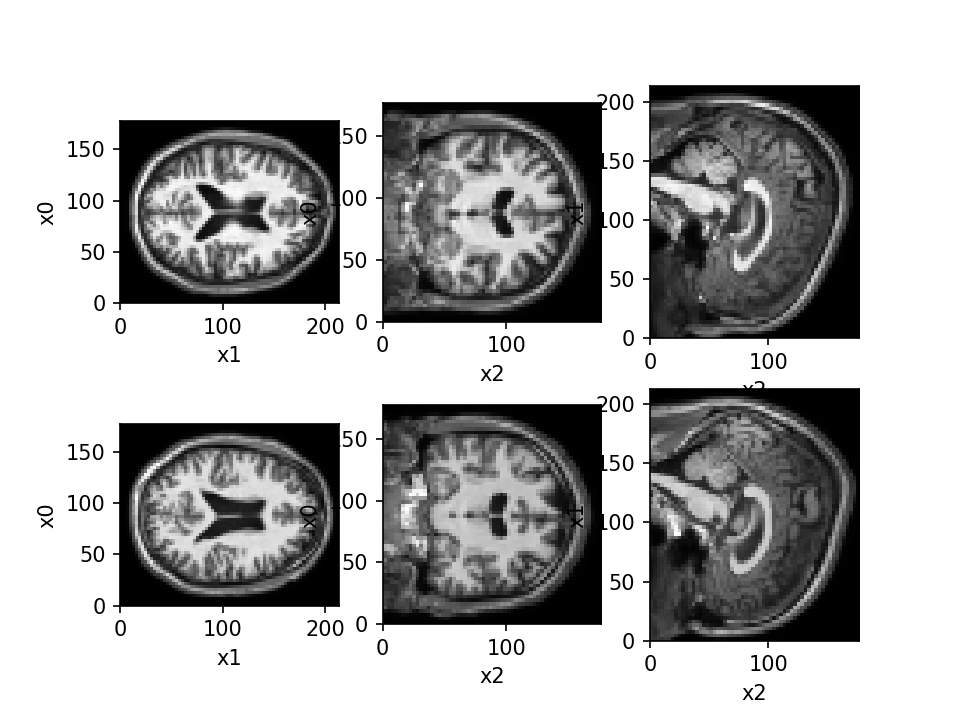

In [8]:
# load images
I = imgI.get_data()[:,:,:,0]
down = 3
I = ss.downsample_image(I,down)
nx = I.shape
dx = imgI.header['pixdim'][1:4]*down
J = imgJ.get_data()[:,:,:,0]
J = ss.downsample_image(J,down)
x0 = np.arange(nx[0])*dx[0]
x1 = np.arange(nx[1])*dx[1]
x2 = np.arange(nx[2])*dx[2]
X0,X1,X2 = np.meshgrid(x0,x1,x2,indexing='ij')
f,ax = plt.subplots(2,3)
ss.imshow_slices(x0,x1,x2,I,ax[0])
ss.imshow_slices(x0,x1,x2,J,ax[1])

<IPython.core.display.Javascript object>


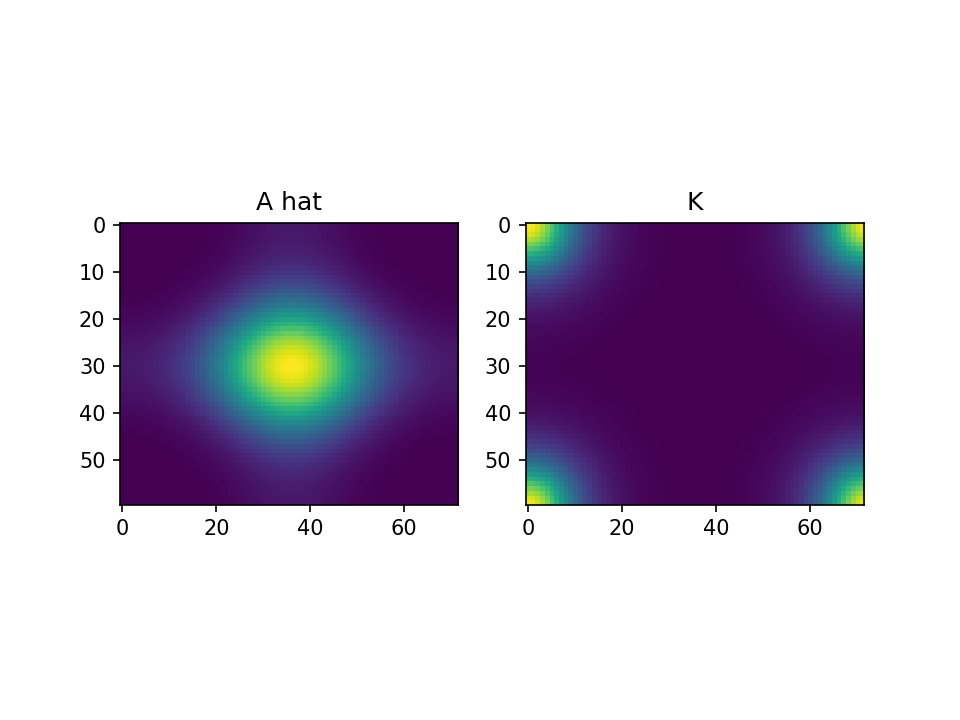

Text(0.5,1,'K')

In [9]:
# encode our energy operator in the Fourier domain using discrete derivatives
f0 = np.arange(nx[0])/(dx[0]*nx[0])
f1 = np.arange(nx[1])/(dx[1]*nx[1])
f2 = np.arange(nx[2])/(dx[2]*nx[2])
F0,F1,F2 = np.meshgrid(f0,f1,f2,indexing='ij')
a = 10.0 # a scale in mm
p = 2
Ahat = (1.0 - 2.0*a**2*((np.cos(2.0*np.pi*dx[0]*F0) - 1.0)/dx[0]**2 
                        + (np.cos(2.0*np.pi*dx[1]*F1) - 1.0)/dx[1]**2
                        + (np.cos(2.0*np.pi*dx[2]*F2) - 1.0)/dx[2]**2))**(2.0*p)
Khat = 1.0/Ahat
K = np.fft.ifftn(Khat).real
f,ax = plt.subplots(1,2)
ax[0].imshow(Ahat[:,:,0])
ax[0].set_title('A hat')
ax[1].imshow(K[:,:,0])
ax[1].set_title('K')

<IPython.core.display.Javascript object>


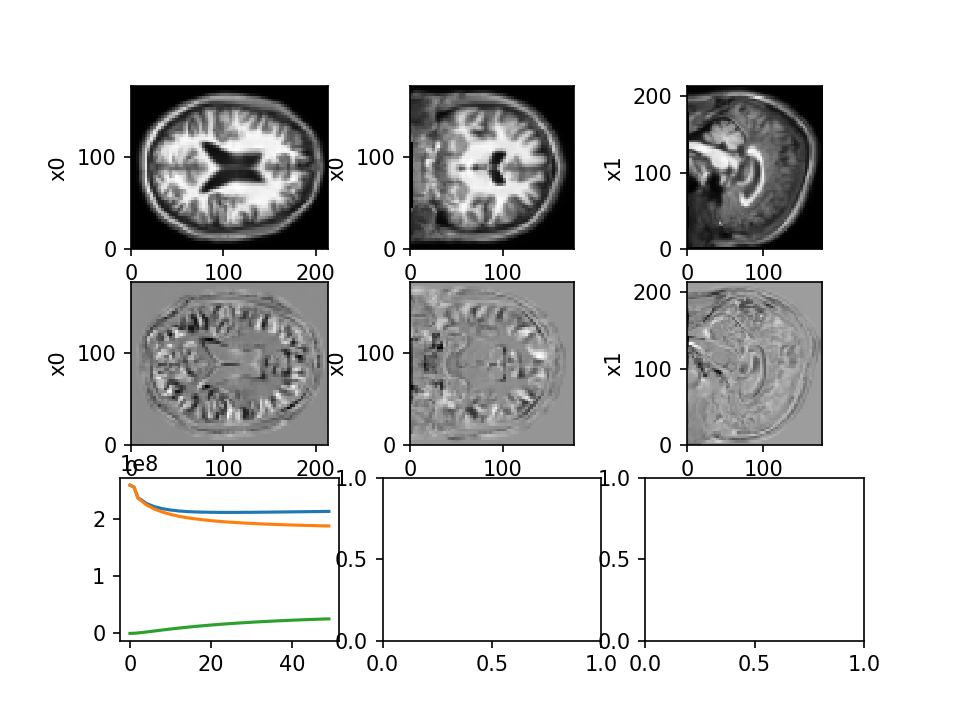

(60, 72, 60, 6)


In [13]:
# for display
f,ax = plt.subplots(3,3)

# parameters
sigma = 2e0 # 1/2/sigma^2 is the parameter in front of image matching integral square error
niter = 50 # how many iterations of gradient descent to run
epsilon = 2.0e-2 # step size in gradient descent

# initialize
vt0, vt1, vt2 = np.zeros((nx[0],nx[1],nx[2],nt)), np.zeros((nx[0],nx[1],nx[2],nt)), np.zeros((nx[0],nx[1],nx[2],nt))
It = np.tile(I[:,:,:,None],(1,1,1,nt+1))
EMAll = []
ERAll = []
EAll = []

# start an optimization loop
for it in range(niter):
    # compute the deformed image by flowing over time        
    phiinv0,phiinv1,phiinv2 = X0,X1,X2
    ER = 0.0
    for t in range(nt):  
        # update phiinv using method of characteristics
        v0, v1, v2 = vt0[:,:,:,t], vt1[:,:,:,t], vt2[:,:,:,t]
        X0s, X1s, X2s = X0-v0*dt, X1-v1*dt, X2-v2*dt
           
        # deal with boundary conditions: subtract identity, use flat boundary conditions, then add identity
        phiinv0 = spi.interpn([x0,x1,x2],phiinv0-X0,np.stack([X0s,X1s,X2s],axis=-1),**interp_args_phiinv)+X0s
        phiinv1 = spi.interpn([x0,x1,x2],phiinv1-X1,np.stack([X0s,X1s,X2s],axis=-1),**interp_args_phiinv)+X1s
        phiinv2 = spi.interpn([x0,x1,x2],phiinv2-X2,np.stack([X0s,X1s,X2s],axis=-1),**interp_args_phiinv)+X2s

        # deform the image
        It[:,:,:,t+1] = spi.interpn([x0,x1,x2],I,np.stack([phiinv0,phiinv1,phiinv2],axis=-1),**interp_args)
    
        # calculate the energy of the flow
        Av0 = np.fft.ifftn(np.fft.fftn(v0)*Ahat).real
        Av1 = np.fft.ifftn(np.fft.fftn(v1)*Ahat).real
        Av2 = np.fft.ifftn(np.fft.fftn(v2)*Ahat).real
        ER += np.sum(v0*Av0 + v1*Av1 + v2*Av2)*0.5*dx[0]*dx[1]*dx[2]*dt
        
    [a.cla() for a in ax[0]]
    ss.imshow_slices(x0,x1,x2,It[:,:,:,-1],ax[0])
    
    # error
    err = It[:,:,:,-1] - J
    lambda1 = -(err)/sigma**2
    [a.cla() for a in ax[1]]
    ss.imshow_slices(x0,x1,x2,err,ax[1])    
    EM = np.sum(err**2/(2.0*sigma**2))*dx[0]*dx[1]
    E = ER+EM    
    EMAll.append(EM)        
    ERAll.append(ER)        
    EAll.append(E)
    ax[2][0].cla()
    ax[2][0].plot(EAll)
    ax[2][0].plot(EMAll)
    ax[2][0].plot(ERAll)
    
    # now we start flowing the error back in time
    phiinv0, phiinv1, phiinv2 = X0,X1,X2
    for t in range(nt-1,-1,-1):
        # update phiinv using method of characteristics, note "+" because we are integrating backward
        v0, v1, v2 = vt0[:,:,:,t], vt1[:,:,:,t], vt2[:,:,:,t]
        X0s, X1s, X2s = X0+v0*dt, X1+v1*dt, X2+v2*dt
        phiinv0 = spi.interpn([x0,x1,x2],phiinv0-X0,np.stack([X0s,X1s,X2s],axis=-1),**interp_args_phiinv)+X0s
        phiinv1 = spi.interpn([x0,x1,x2],phiinv1-X1,np.stack([X0s,X1s,X2s],axis=-1),**interp_args_phiinv)+X1s
        phiinv2 = spi.interpn([x0,x1,x2],phiinv2-X2,np.stack([X0s,X1s,X2s],axis=-1),**interp_args_phiinv)+X2s
        
        # find the determinant of Jacobian
        phiinv0_0,phiinv0_1,phiinv0_2 = np.gradient(phiinv0,dx[0],dx[1],dx[2])
        phiinv1_0,phiinv1_1,phiinv1_2 = np.gradient(phiinv1,dx[0],dx[1],dx[2])
        phiinv2_0,phiinv2_1,phiinv2_2 = np.gradient(phiinv2,dx[0],dx[1],dx[2])
        detjac = phiinv0_0*(phiinv1_1*phiinv2_2 - phiinv1_2*phiinv2_1)\
            - phiinv0_1*(phiinv1_0*phiinv2_2 - phiinv1_2*phiinv2_0)\
            + phiinv0_2*(phiinv1_0*phiinv2_1 - phiinv1_1*phiinv2_0)
        
        # find lambda_t
        lambdat = spi.interpn([x0,x1,x2],lambda1,np.stack([phiinv0,phiinv1,phiinv2],axis=-1),**interp_args)*detjac
        
        # get the gradient of the image at this time
        I_0, I_1, I_2 = np.gradient(It[:,:,:,t],dx[0],dx[1],dx[2])
        
        # initialize the gradient with the matching term
        grad0, grad1, grad2 = lambdat*I_0, lambdat*I_1, lambdat*I_2
        
        # smooth it
        grad0 = np.fft.ifftn(np.fft.fftn(grad0)*Khat).real
        grad1 = np.fft.ifftn(np.fft.fftn(grad1)*Khat).real
        grad2 = np.fft.ifftn(np.fft.fftn(grad2)*Khat).real

        # add the regularization term
        grad0 += v0
        grad1 += v1
        grad2 += v2

        # update
        vt0[:,:,:,t] -= epsilon*grad0
        vt1[:,:,:,t] -= epsilon*grad1
        vt2[:,:,:,t] -= epsilon*grad2
    
    f.canvas.draw()

We'd like to do gradient descent over $v$ by taking a perturbatoin $v \mapsto v + \epsilon \delta v$.

We will want to know how a perturbation in $v$ affects $\varphi_t^{-1}$.  We'll write
\begin{align*}
\varphi_1^{-1}(x) &= x + \int -D\varphi_t^{-1} v_t dt
\end{align*}
Let's assume $\varphi_t \mapsto \varphi_t^{-1} + \epsilon \delta \varphi^{-1}_t$ and find the relationship between $\delta \varphi^{-1}$ and $\delta v$.
\begin{align}
&\frac{d}{d\epsilon}\frac{d}{dt} \varphi^{-1}_t + \epsilon \delta \varphi^{-1}_t + D(\varphi_t^{-1} + \epsilon \delta \varphi_t^{-1})(v_t + \epsilon \delta v_t)\bigg|_{\epsilon = 0} = 0\\
&\implies \frac{d}{dt}\delta \varphi^{-1}_t + D\varphi^{-1}_t \delta v_t + D\delta \varphi^{-1}_t v_t = 0
\end{align}
We can write this as $\frac{d}{dt} \delta \varphi^{-1}_t + D\delta \varphi^{-1}v_t = -D\varphi^{-1}_t\delta v_t $